# Comparação entre Abordagens de Visão Computacional  
### YOLOv5 Adaptado vs YOLOv5 Tradicional vs CNN do Zero  
#### Projeto PBL – Fase 6 • FIAP • Entrega 2  

---

Nesta segunda entrega do Projeto da Fase 6, realizamos uma **análise comparativa entre três abordagens de visão computacional** aplicadas à classificação e detecção de veículos (**carros e motos**), reutilizando o dataset desenvolvido na Entrega 1.

As abordagens comparadas são:

1. ✅ **YOLOv5 Adaptado** – Treinado com dataset customizado (Entrega 1)
2. 📦 **YOLOv5 Tradicional** – Modelo pré-treinado, sem re-treinamento
3. 🧱 **CNN do Zero** – Modelo de classificação simples, com treinamento de 30 e 60 épocas

O objetivo desta etapa é avaliar criticamente essas soluções quanto a:
- Facilidade de uso e integração
- Precisão do modelo
- Tempo de treinamento e/ou customização
- Tempo de inferência

A seguir, iniciamos a preparação do ambiente para a execução dos experimentos.



## Preparação do Ambiente



### Imports Iniciais

Nesta célula, são realizados os imports essenciais para execução do notebook, incluindo:

- Bibliotecas de sistema (`os`, `subprocess`, `glob`, `time`)
- Bibliotecas para verificação de hardware e uso de GPU (`torch`)
- Bibliotecas de visualização para análise dos resultados (`matplotlib`)
- Bibliotecas para manipulação de dados (`pandas`, `numpy`)

In [20]:
import os
import torch
import subprocess
import datetime
import time
import sys
import warnings
import contextlib
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np
from IPython.display import FileLink
from keras.saving import save_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


### Verificação do Ambiente e da GPU

Antes de iniciar o treinamento do modelo YOLOv5, é importante verificar se o ambiente está utilizando uma GPU. O uso de GPU é altamente recomendado, especialmente no Google Colab, pois acelera significativamente o processo de treinamento e evita possíveis interrupções por tempo limite.

> 💡 Este notebook pode ser executado tanto no **Google Colab** quanto **localmente**. A verificação abaixo ajuda a garantir que os recursos computacionais estão adequados antes de seguir.

In [2]:
# Função auxiliar para detectar se está no Colab
def esta_no_colab():
    return 'COLAB_GPU' in os.environ

# Verificação do ambiente
if esta_no_colab():
    print("🟢 Ambiente detectado: Google Colab")
else:
    print("💻 Ambiente detectado: Execução Local")

# Verificação de GPU
if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name(0)
    print(f"\033[92m✅ GPU disponível:\033[0m {device_name}")
    print("O ambiente está configurado corretamente para o treinamento.")
else:
    print("\033[91m❌ ATENÇÃO: GPU não disponível. O notebook está executando em CPU.\033[0m\n")
    print("❗ O treinamento com YOLOv5 em CPU pode ser extremamente lento e sujeito a interrupções por tempo limite.\n")
    
    if esta_no_colab():
        print("\033[1mRecomendações para ativar GPU no Colab:\033[0m")
        print("- Vá até o menu 'Ambiente de execução > Alterar tipo de ambiente de execução'")
        print("- Selecione 'GPU' como acelerador de hardware e clique em 'Salvar'")
        print("- O ambiente será reiniciado. Após a reinicialização, reexecute esta célula antes de continuar.")


💻 Ambiente detectado: Execução Local
✅ GPU disponível: NVIDIA GeForce RTX 3060 Laptop GPU
O ambiente está configurado corretamente para o treinamento.


### Conexão com o Google Drive ou Ambiente Local

Nesta etapa, o notebook verifica automaticamente se está sendo executado no Google Colab ou em ambiente local. Em seguida, realiza a montagem do Google Drive (caso Colab) e define os caminhos apropriados para acessar o dataset e o arquivo de configuração `.yaml` do YOLOv5.

Isso garante que o notebook funcione de forma flexível, independentemente do ambiente de execução.

In [4]:
try:
    from google.colab import drive
    print("✅ Executando no Google Colab")

    # Monta o Google Drive se necessário
    drive_path = "/content/drive"
    mydrive_path = os.path.join(drive_path, "MyDrive")
    if not os.path.exists(mydrive_path):
        print("🔄 Google Drive não está montado. Montando agora...")
        drive.mount(drive_path)
    else:
        drive.mount(drive_path, force_remount=True)
        print("✅ Google Drive já está montado.")

    # Caminho no Google Drive
    dataset_dir = os.path.join(mydrive_path, "1TIAOR20242_FASE6_CAP1")
    yaml_filename = "veiculos.yaml"
    pathConfiguration = os.path.join(dataset_dir, "configuration", yaml_filename)

except ImportError:
    print("✅ Executando localmente")

    # Caminho local padrão
    dataset_dir = os.path.abspath("../")
    yaml_filename = "veiculos_local.yaml"
    pathConfiguration = os.path.join(dataset_dir, "configuration", yaml_filename)

    # Se não encontrar, tenta um nível acima
    if not os.path.exists(pathConfiguration):
        dataset_dir = os.path.abspath("../../")
        pathConfiguration = os.path.join(dataset_dir, "configuration", yaml_filename)

# Validação final
if not os.path.exists(pathConfiguration):
    raise FileNotFoundError(f"Arquivo não encontrado: {pathConfiguration}")

# Exibe os caminhos definidos
print(f"Caminho dos Datasets: {dataset_dir}")
print(f"Arquivo de configuração: {pathConfiguration}")


✅ Executando localmente
Caminho dos Datasets: /home/joseandre/fiap_projetos/1TIAOR20242_FASE6_CAP1
Arquivo de configuração: /home/joseandre/fiap_projetos/1TIAOR20242_FASE6_CAP1/configuration/veiculos_local.yaml


### 📋 Verificação de Integridade dos Dados da Entrega 1

Antes de continuar, o notebook realiza uma verificação básica para garantir que os dados da Entrega 1 estão corretamente organizados e disponíveis.  
Serão verificadas as seguintes pastas:

- `images/train`, `images/val`, `images/test`
- `labels/train`, `labels/val`, `labels/test`

Se algum diretório estiver ausente, uma exceção será lançada para evitar erros futuros durante o treinamento ou avaliação dos modelos.


In [5]:
# 📋 Verificação de integridade das pastas esperadas

subpastas_esperadas = [
    "dataset_images/images/train",
    "dataset_images/images/val",
    "dataset_images/images/test",
    "dataset_images/labels/train",
    "dataset_images/labels/val",
    "dataset_images/labels/test"
]

faltando = []

for sub in subpastas_esperadas:
    caminho = os.path.join(dataset_dir, sub)
    if not os.path.exists(caminho):
        faltando.append(caminho)

if faltando:
    print("❌ As seguintes pastas estão faltando no projeto:")
    for f in faltando:
        print(f"  - {f}")
    raise FileNotFoundError("🚫 Estrutura de dados incompleta. Corrija antes de continuar.")
else:
    print("✅ Estrutura de dados da Entrega 1 verificada com sucesso.")


✅ Estrutura de dados da Entrega 1 verificada com sucesso.


## Aplicação das Abordagens de Visão Computacional

Nesta seção, aplicaremos três diferentes abordagens para resolver a tarefa de classificação e detecção de veículos:

1. **YOLOv5 Adaptado** – Modelo treinado com dataset customizado na Entrega 1  
2. **YOLOv5 Tradicional** – Modelo pré-treinado, sem re-treinamento  
3. **CNN do Zero** – Arquitetura simples desenvolvida do zero, treinada com 30 e 60 épocas

O objetivo é comparar as soluções com base em desempenho, facilidade de uso e tempo de execução.


### Referência: Resultado da Entrega 1 (YOLOv5 Adaptado - 60 épocas)

Nesta abordagem, reutilizamos os **resultados obtidos na Entrega 1** com o modelo YOLOv5 adaptado, treinado com um dataset customizado contendo imagens de **carros e motos**.

O modelo foi treinado por **60 épocas** e atingiu os melhores resultados do experimento. Abaixo, carregamos o arquivo `results.csv` para extrair as principais métricas da última época de treinamento.

In [9]:
import pandas as pd

# Caminho para o CSV com os resultados do modelo treinado na Entrega 1
results_path = os.path.join("yolov5", "runs", "train", "veiculos_yolo_60ep", "results.csv")

# Verifica se o arquivo existe
if not os.path.exists(results_path):
    raise FileNotFoundError(f"🚫 Arquivo de resultados não encontrado: {results_path}")

# Carrega o CSV
df = pd.read_csv(results_path)
df.columns = df.columns.str.strip()  # Limpeza de espaços extras

# Pega a última linha (última época)
ultima_epoca = df.iloc[-1]

# Exibe as métricas principais
print("📊 Desempenho do YOLOv5 Adaptado – 60 Épocas:")
print(f"✔️ Precisão       : {ultima_epoca['metrics/precision']:.4f}")
print(f"✔️ Recall          : {ultima_epoca['metrics/recall']:.4f}")
print(f"✔️ mAP@0.5         : {ultima_epoca['metrics/mAP_0.5']:.4f}")
print(f"✔️ mAP@0.5:0.95    : {ultima_epoca['metrics/mAP_0.5:0.95']:.4f}")


📊 Desempenho do YOLOv5 Adaptado – 60 Épocas:
✔️ Precisão       : 0.9652
✔️ Recall          : 0.9963
✔️ mAP@0.5         : 0.9950
✔️ mAP@0.5:0.95    : 0.7835


#### 📈 Métricas Finais - YOLOv5 Adaptado (60 Épocas)

Esses resultados reforçam que o modelo treinado com 60 épocas teve excelente desempenho, tanto em termos de cobertura (recall) quanto de acurácia nas detecções.


## YOLOv5 Tradicional (Pré-treinado)

Nesta abordagem, utilizamos o modelo pré-treinado `yolov5s.pt`, fornecido pelo repositório oficial da Ultralytics, treinado com o dataset COCO (Common Objects in Context).

Este modelo é aplicado diretamente sobre o conjunto de imagens de **teste** da nossa base, **sem qualquer re-treinamento**, permitindo avaliar seu desempenho genérico na tarefa de detecção de **carros e motos**.

> 💡 Espera-se que o desempenho seja inferior ao modelo treinado especificamente, porém é uma boa referência de "modelo pronto para uso".


In [11]:
nome_treinamento = "yolo_tradicional"

# Caminho das imagens de teste
test_images_dir = os.path.join(dataset_dir, "dataset_images", "images", "test")

# Parâmetros utilizados:
# --weights: define o modelo YOLOv5 a ser utilizado (pré-treinado 'yolov5s.pt')
# --img: tamanho da imagem de entrada (640x640 pixels)
# --conf: nível mínimo de confiança para considerar uma detecção
# --source: diretório com as imagens do conjunto de teste
# --name: nome da pasta onde os resultados da inferência serão salvos (dentro de runs/detect/)
# --exist-ok: permite sobrescrever a pasta de saída se ela já existir

# Marca o início da execução
inicio = time.time()

# Executa a inferência com o modelo pré-treinado
!python yolov5/detect.py \
  --weights yolov5s.pt \
  --img 640 \
  --conf 0.25 \
  --source {test_images_dir} \
  --name {nome_treinamento}_test \
  --exist-ok

# Marca o fim da execução e calcula a duração
fim = time.time()
print(f"Tempo de inferência com YOLO pré-treinado: {fim - inicio:.2f} segundos")


detect: weights=['yolov5s.pt'], source=/home/joseandre/fiap_projetos/1TIAOR20242_FASE6_CAP1/dataset_images/images/test, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=yolo_tradicional_test, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-416-gfe1d4d99 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
image 1/8 /home/joseandre/fiap_projetos/1TIAOR20242_FASE6_CAP1/dataset_images/images/test/Imagem073.jpg: 480x640 3 cars, 1 motorcycle, 44.6ms
image 2/8 /home/joseandre/fiap_projetos/1TIAOR20242_FASE6_CAP1/dataset_ima

### Visualização dos resultados da YOLOv5 Tradicional

Abaixo estão algumas imagens do conjunto de teste processadas pelo modelo pré-treinado YOLOv5s. O objetivo é observar quais objetos foram detectados, como foram classificados e se há consistência nas detecções para as classes de interesse (carro e moto).


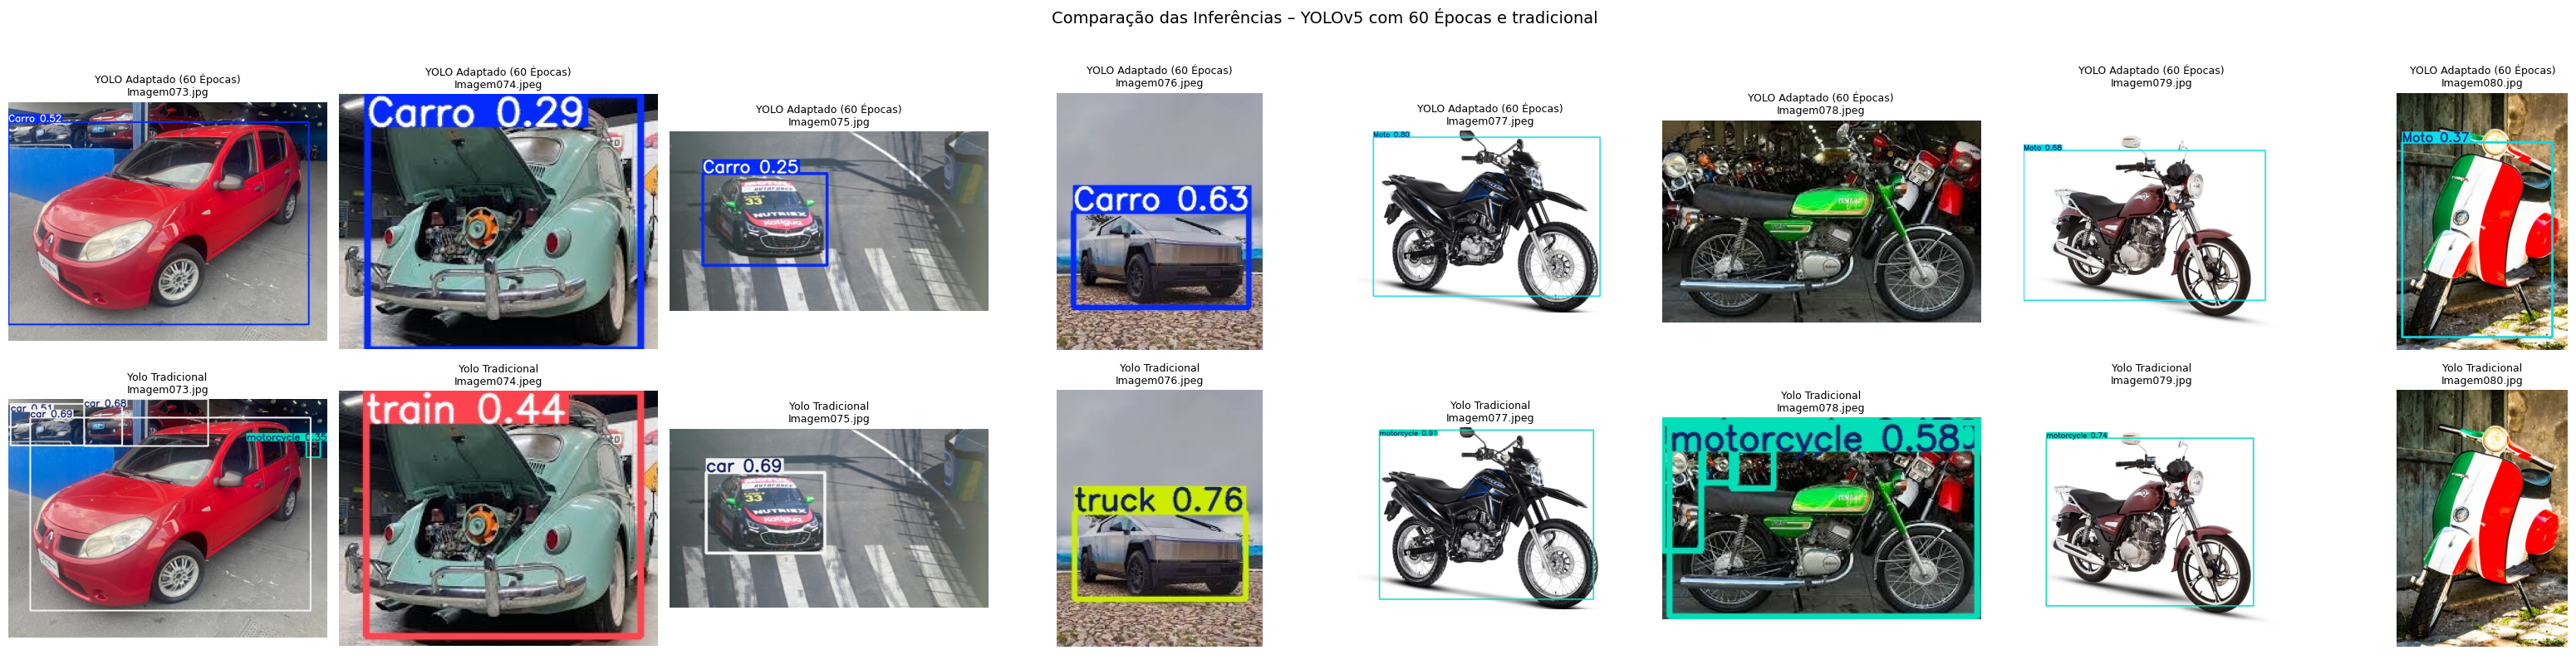

In [12]:
# Diretórios de saída
dir_60 = f'yolov5/runs/detect/veiculos_yolo_60ep_test'
dir_tradicional = f'yolov5/runs/detect/yolo_tradicional_test'

def get_images(folder, n=8):
    exts = ('*.jpg','*.jpeg','*.png','*.bmp')
    imgs = []
    for e in exts:
        imgs += glob.glob(os.path.join(folder, e))
    return sorted(imgs)[:n]

# Lista de imagens detectadas (as mesmas usadas nos testes)
imgs_60 = get_images(dir_60)
imgs_tradicional = get_images(dir_tradicional)

# Número máximo de imagens
num_imgs = min(8, len(imgs_60), len(imgs_tradicional))

fig, axes = plt.subplots(2, num_imgs, figsize=(num_imgs * 4, 8))

for i in range(num_imgs):
    # Linha 0 = 60 épocas
    img30 = mpimg.imread(imgs_60[i])
    axes[0, i].imshow(img30)
    axes[0, i].set_title(f'YOLO Adaptado (60 Épocas)\n{os.path.basename(imgs_60[i])}', fontsize=9)
    axes[0, i].axis('off')

    # Linha 1 = YOLOv5 Tradicional (pré-treinado)
    img60 = mpimg.imread(imgs_tradicional[i])
    axes[1, i].imshow(img60)
    axes[1, i].set_title(f'Yolo Tradicional\n{os.path.basename(imgs_tradicional[i])}', fontsize=9)
    axes[1, i].axis('off')

plt.suptitle("Comparação das Inferências – YOLOv5 com 60 Épocas e tradicional", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # espaço para o título
plt.show()



### Análise de desempenho do modelo YOLOv5 Tradicional (Pré-treinado)


Ao aplicar o modelo YOLOv5s pré-treinado (sem re-treinamento) sobre as imagens do conjunto de teste, foram observadas as seguintes características e comportamentos:

#### 🔹 Detecções realizadas
- O modelo foi capaz de detectar **carros** e **motos**, que são classes presentes no dataset COCO (base de treinamento do YOLOv5 pré-treinado).
- Em algumas imagens, foi capaz de detectar **mais de um objeto da mesma classe**, como múltiplos carros ou motos, demonstrando uma boa capacidade de identificação em ambientes com múltiplas ocorrências.
- Algumas imagens apresentaram **detecções incorretas ou irrelevantes**, como a classificação de "train" ou "truck", indicando limitações no foco da aplicação.

#### 🔹 Acertos e limitações por imagem
- **Imagem 073**: Detecção de 3 carros e 1 moto, indicando boa sensibilidade.
- **Imagem 074**: Detecção incorreta como "train", devido à vista traseira incomum do fusca.
- **Imagem 075**: Detecção correta de um carro.
- **Imagem 076**: Detecção como "truck" (possivelmente confundido com o design do Tesla Cybertruck).
- **Imagem 077**: Detecção correta de uma moto.
- **Imagem 078**: Detecção de 4 motos, indicando alta sensibilidade, mas possível excesso.
- **Imagem 079**: Detecção correta de uma moto.
- **Imagem 080**: Nenhuma detecção (moto tipo Vespa, possivelmente fora do padrão aprendido).

#### 🔹 Tempo de inferência
- O tempo total de inferência foi de aproximadamente **6,19 segundos** para processar as 8 imagens do conjunto de teste, o que representa uma performance adequada para aplicações em tempo real ou embarcadas.

#### 🔹 Robustez e generalização
- O modelo demonstrou **capacidade de generalizar** bem para contextos diversos, sendo capaz de detectar objetos mesmo em imagens não padronizadas.
- A presença de falsos positivos e detecções de classes fora do escopo do projeto reforça o caráter **genérico** do modelo.

Esses resultados demonstram que o modelo YOLOv5 pré-treinado, mesmo sem ajustes, consegue fornecer **resultados relevantes** em ambientes variados, desde que as classes estejam contempladas em seu conjunto de treinamento original.


### Conclusão parcial – YOLOv5 Tradicional (Pré-treinado)

O modelo YOLOv5s pré-treinado, utilizado sem re-treinamento, apresentou um desempenho satisfatório ao ser aplicado diretamente sobre as imagens do conjunto de teste do projeto.

Mesmo sem ter sido treinado com o dataset específico, o modelo foi capaz de detectar corretamente diversas ocorrências das classes "car" e "motorcycle", mostrando uma boa generalização para objetos presentes em seu dataset original (COCO).

Além disso, o modelo demonstrou:
- **Capacidade de identificar múltiplos objetos por imagem**, o que é relevante em ambientes complexos.
- **Tempo de inferência adequado** (6,19 segundos para 8 imagens), tornando-o viável para aplicações práticas.
- **Alguns falsos positivos ou classificações irrelevantes**, como "train" e "truck", esperados em um modelo genérico.

Por outro lado, a detecção incorreta de objetos incomuns (como o Tesla Cybertruck ou a traseira aberta de um fusca) e a ausência de detecção em casos menos padronizados (como a moto Vespa) indicam **limitações relacionadas à representatividade do dataset de origem** e à falta de especialização no domínio do projeto.

Em resumo, o YOLO pré-treinado é uma ferramenta prática e eficaz para uso geral, oferecendo bons resultados iniciais mesmo sem personalização. No entanto, **pode não atender com a precisão exigida em contextos específicos**, como os esperados por um cliente com necessidades claramente definidas.


## 2. Classificação com CNN do Zero (Carro vs Moto)



## Abordagem 3: CNN Desenvolvida do Zero

Nesta etapa, será implementada uma **rede neural convolucional simples**, treinada do zero para classificar imagens entre duas categorias: **"carro" e "moto"**.

O experimento será conduzido em duas etapas:

- 🔁 Treinamento com **30 épocas**
- 🔁 Treinamento com **60 épocas**

Diferente do modelo YOLO, que realiza detecção de objetos, a CNN será responsável apenas pela **classificação da imagem como um todo**, com base em características visuais.

Para isso, utilizaremos as mesmas imagens da Entrega 1, reestruturando o dataset para seguir o padrão esperado por bibliotecas como `ImageDataGenerator` (Keras) ou `ImageFolder` (PyTorch).

A estrutura esperada do diretório de dados é a seguinte:



```
📦 1TIAOR20242_FASE6_CAP1
│── 📁 dataset_cnn           # Pasta principal para classificação com CNN
│   ├── 📁 train             # Imagens utilizadas para o treinamento (64 imagens por classe)
│   │   ├── 📁 carro         # Imagens da classe "carro"
│   │   ├── 📁 moto          # Imagens da classe "moto"
│   ├── 📁 val               # Imagens utilizadas para validação (8 imagens por classe)
│   │   ├── 📁 carro         # Imagens da classe "carro"
│   │   ├── 📁 moto          # Imagens da classe "moto"
│   ├── 📁 test              Imagens utilizadas para avaliação final (8 imagens por classe)
│   │   ├── 📁 carro         # Imagens da classe "carro"
│   │   ├── 📁 moto          # Imagens da classe "moto"
```

Com essa organização, é possível carregar as imagens automaticamente com os respectivos rótulos, simplificando o processo de preparação do dataset para a CNN.

### 📁 Definição do Caminho para os Dados da CNN

Esta célula detecta automaticamente se o notebook está sendo executado no **Google Colab** ou **localmente**, e define o caminho adequado para o diretório `dataset_cnn`, que contém as imagens organizadas por classe para a abordagem de classificação com CNN.

Se estiver no Colab, o Google Drive será montado para acessar os dados.


In [ ]:
# Verifica se o ambiente é Google Colab ou local
try:
    # Verifica se está no Google Colab
    from google.colab import drive
    print("✅ Executando no Google Colab")

    # Verifica se o Google Drive já está montado
    if not os.path.exists('/content/drive/MyDrive'):
        print("🔄 Google Drive não está montado. Montando agora...")
        drive.mount('/content/drive')
    else:
        drive.mount('/content/drive', force_remount=True)
        print("✅ Google Drive já está montado.")

    # Caminho no Google Drive
    dataset_dir = "/content/drive/MyDrive/1TIAOR20242_FASE6_CAP1/dataset_cnn"

except ImportError:
    # Caso não esteja no Colab, executa localmente
    print("✅ Executando localmente")

    # Caminho local
    dataset_dir = os.path.abspath("../dataset_cnn")

# Exemplo de uso do caminho
print(f"Caminho dos Datasets: {dataset_dir}")

✅ Executando localmente
Caminho dos Datasets: /home/joseandre/fiap_projetos/1TIAOR20242_FASE6_CAP1/dataset_cnn


### 🔍 Validação da Estrutura do Diretório da CNN

Antes de prosseguir com o carregamento dos dados, o notebook valida se o diretório `dataset_cnn` contém as subpastas essenciais:

- `train/`
- `val/`
- `test/`

Caso alguma dessas pastas esteja ausente, uma mensagem de alerta será exibida para correção da estrutura do dataset.


In [ ]:
# Função para validar as subpastas
def validar_subpastas(dataset_dir):
    subpastas_necessarias = ['test', 'val', 'train']
    subpastas_existentes = os.listdir(dataset_dir) if os.path.exists(dataset_dir) else []

    # Verifica se todas as subpastas necessárias estão presentes
    subpastas_faltando = [pasta for pasta in subpastas_necessarias if pasta not in subpastas_existentes]

    if subpastas_faltando:
        print("\033[91m❌ ERRO: As seguintes subpastas estão faltando no diretório:\033[0m")
        for pasta in subpastas_faltando:
            print(f"  - {pasta}")
        print("\033[93m⚠️ Verifique o caminho do dataset e a estrutura esperada.\033[0m")
    else:
        print("\033[92m✅ Todas as subpastas necessárias estão presentes:\033[0m")
        for pasta in subpastas_necessarias:
            print(f"  - {pasta}")

# Valida as subpastas
validar_subpastas(dataset_dir)

✅ Todas as subpastas necessárias estão presentes:
  - test
  - val
  - train


### 📂 Carregamento e Pré-processamento do Dataset

Nesta etapa, utilizamos o `ImageDataGenerator` para:

- Reescalar os pixels das imagens (normalização)
- Organizar os dados em lotes (batches)
- Criar geradores para treino, validação e teste com base na estrutura de pastas definida anteriormente

Isso facilita o uso dos dados diretamente na CNN, com carregamento eficiente e automático de rótulos.


In [19]:
# Parâmetros comuns
img_size = (224, 224)
batch_size = 16

# Inicializa os geradores
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    os.path.join(dataset_dir, "train"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

val_generator = datagen.flow_from_directory(
    os.path.join(dataset_dir, "val"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_generator = datagen.flow_from_directory(
    os.path.join(dataset_dir, "test"),
    target_size=img_size,
    batch_size=1,  # para avaliação imagem a imagem
    class_mode="categorical",
    shuffle=False
)


Found 64 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


### Definição da Arquitetura da CNN

A arquitetura definida a seguir é uma **rede neural convolucional simples**, projetada para realizar a **classificação binária de imagens** entre as categorias **carro** e **moto**.

Ela é composta por:

- 🔍 **Blocos `Conv2D` + `MaxPooling2D`**: responsáveis por extrair padrões locais da imagem (bordas, texturas, formas)
- 🧠 **Camadas `Dense`**: responsáveis por aprender combinações dessas características para tomar a decisão final
- 🛡️ **Regularização com `Dropout`**: reduz o risco de overfitting
- 🎯 **Camada de saída `Dense(2)` com `softmax`**: gera uma probabilidade para cada classe, permitindo a classificação da imagem como "carro" ou "moto"

> 💡 Essa arquitetura é ideal para datasets pequenos e tarefas de classificação visual simples.


In [22]:
# Função para construir a CNN com formato e número de classes definidos
def construir_modelo_cnn(input_shape=(224, 224, 3), num_classes=2):
    """
    input_shape: tupla com altura, largura e canais da imagem de entrada (128x128 RGB)
    num_classes: número de classes de saída (carro e moto → 2 classes)
    """

    # Define um modelo sequencial (camadas são adicionadas em sequência)
    model = Sequential([

        # 🧩 Primeira camada convolucional: aplica 32 filtros 3x3 para extrair padrões simples (bordas, texturas)
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),

        # 🔽 Camada de MaxPooling: reduz dimensionalidade, retendo as características mais importantes (reduz sobreajuste e custo)
        MaxPooling2D(pool_size=(2, 2)),

        # 🧩 Segunda camada convolucional: agora com 64 filtros, extraindo padrões mais complexos
        Conv2D(64, (3, 3), activation='relu'),

        # 🔽 Outro MaxPooling para redução adicional da dimensionalidade espacial
        MaxPooling2D(pool_size=(2, 2)),

        # 🧱 Flatten: "achata" a saída 2D das convoluções em um vetor 1D para alimentar as camadas densas
        Flatten(),

        # 🧠 Dense: camada densa totalmente conectada com 128 neurônios, responsável por aprender combinações das features extraídas
        Dense(128, activation='relu'),

        # 🛡️ Dropout: desativa aleatoriamente 50% dos neurônios durante o treinamento para evitar overfitting
        Dropout(0.5),

        # 🎯 Camada de saída: 2 neurônios com softmax para classificação entre as 2 classes (probabilidades somando 1)
        Dense(num_classes, activation='softmax')
    ])
    
    # 🧪 Compilação do modelo
    model.compile(
        optimizer='adam',                      # Algoritmo de otimização adaptativo e eficiente
        loss='categorical_crossentropy',       # Função de perda usada para classificação multiclasse (com one-hot encoding)
        metrics=['accuracy']                   # Métrica para monitorar durante o treino e validação
    )
    
    return model  # Retorna o modelo construído e compilado, pronto para treino

@contextlib.contextmanager
def ocultar_output():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr


def treino_silencioso(model, train_gen, val_gen, epochs, nome_modelo):
    print(f"\n🚀 Iniciando treinamento: {nome_modelo} ({epochs} épocas)")
    inicio = time.time()

    with ocultar_output():
        history = model.fit(train_gen, validation_data=val_gen, epochs=epochs, verbose=0)

    fim = time.time()
    duracao = fim - inicio
    print(f"✅ Treinamento finalizado: {nome_modelo} | ⏱️ Tempo: {duracao:.2f} segundos")
    return history

### Treinamento e Salvamento da CNN (30 e 60 Épocas)

Nesta etapa, a rede neural convolucional (CNN) será treinada a partir do zero utilizando o dataset customizado de **carros** e **motos**.

Serão executados dois treinamentos distintos:

- 🔁 CNN com **30 épocas**
- 🔁 CNN com **60 épocas**

Ambos os modelos serão treinados silenciosamente para manter o notebook limpo, com o tempo total registrado ao final.  
Após o treinamento, os modelos serão salvos no formato `.keras`, permitindo sua reutilização em inferências ou comparações posteriores.

Os modelos serão armazenados no diretório `../models/` com os seguintes nomes:

- `cnn_30ep.keras`
- `cnn_60ep.keras`


In [23]:
os.makedirs("../models", exist_ok=True)

# Treinar CNN com 30 épocas
model_30 = construir_modelo_cnn()
history_30 = treino_silencioso(model_30, train_generator, val_generator, 30, "CNN - 30 Épocas")

# Treinar CNN com 60 épocas
model_60 = construir_modelo_cnn()
history_60 = treino_silencioso(model_60, train_generator, val_generator, 60, "CNN - 60 Épocas")

save_model(model_30, "../models/cnn_30ep.keras")
save_model(model_60, "../models/cnn_60ep.keras")

print("💾 Modelos salvos: cnn_30ep.keras e cnn_60ep.keras")




🚀 Iniciando treinamento: CNN - 30 Épocas (30 épocas)
✅ Treinamento finalizado: CNN - 30 Épocas | ⏱️ Tempo: 49.42 segundos

🚀 Iniciando treinamento: CNN - 60 Épocas (60 épocas)
✅ Treinamento finalizado: CNN - 60 Épocas | ⏱️ Tempo: 93.07 segundos
💾 Modelos salvos: cnn_30ep.keras e cnn_60ep.keras


### Análise Visual dos Treinamentos com CNN – 30 vs 60 Épocas

A seguir, comparamos o desempenho dos modelos `model_30` e `model_60`, treinados com 30 e 60 épocas, respectivamente.  
Os gráficos mostram a **evolução da acurácia** e da **função de perda (loss)** em ambos os casos, durante o treinamento e validação.

Essa comparação visual ajuda a responder perguntas como:

- O modelo de 60 épocas realmente aprendeu mais?
- Houve overfitting (memorização) nas últimas épocas?
- Os resultados estabilizaram ou ainda estavam em melhora?



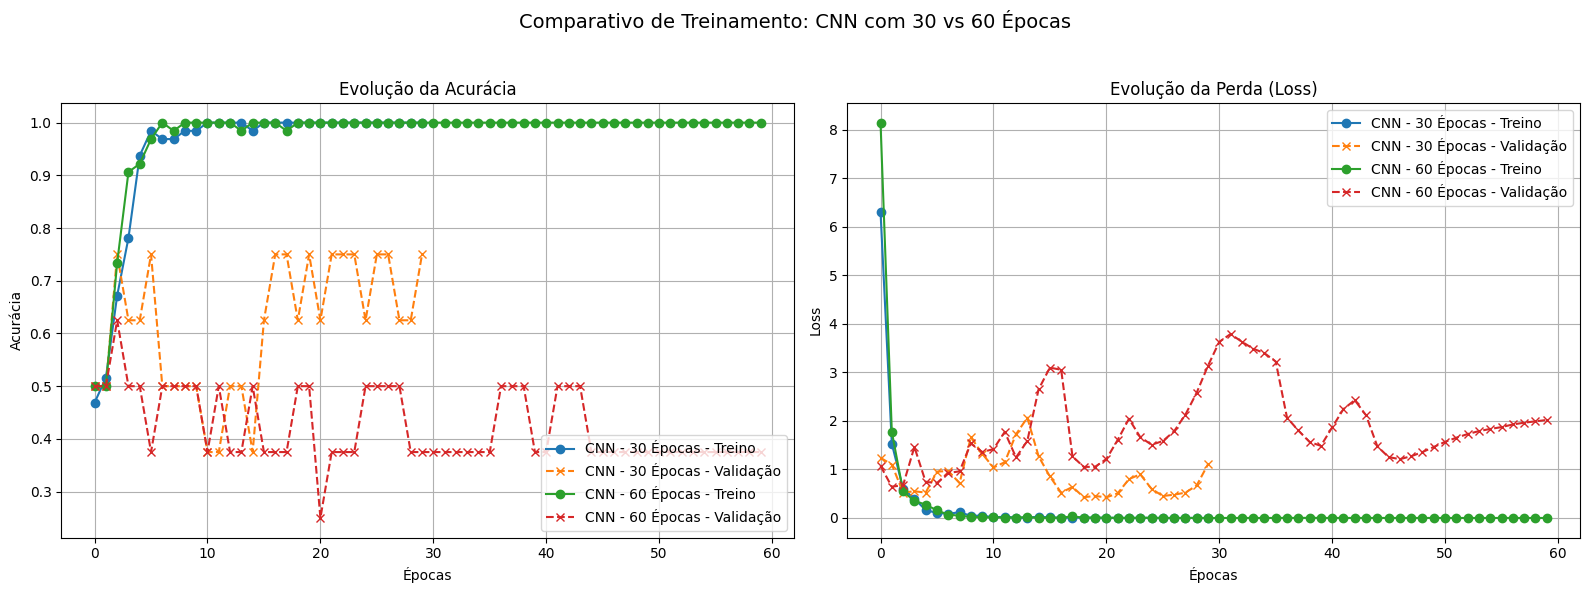

In [27]:
def comparar_treinos(history_30, history_60, label_modelo_30="CNN - 30 Épocas", label_modelo_60="CNN - 60 Épocas"):
    plt.figure(figsize=(16, 6))

    # Acurácia
    plt.subplot(1, 2, 1)
    plt.plot(history_30.history['accuracy'], label=f'{label_modelo_30} - Treino', linestyle='-', marker='o')
    plt.plot(history_30.history['val_accuracy'], label=f'{label_modelo_30} - Validação', linestyle='--', marker='x')
    plt.plot(history_60.history['accuracy'], label=f'{label_modelo_60} - Treino', linestyle='-', marker='o')
    plt.plot(history_60.history['val_accuracy'], label=f'{label_modelo_60} - Validação', linestyle='--', marker='x')
    plt.title('Evolução da Acurácia')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Perda
    plt.subplot(1, 2, 2)
    plt.plot(history_30.history['loss'], label=f'{label_modelo_30} - Treino', linestyle='-', marker='o')
    plt.plot(history_30.history['val_loss'], label=f'{label_modelo_30} - Validação', linestyle='--', marker='x')
    plt.plot(history_60.history['loss'], label=f'{label_modelo_60} - Treino', linestyle='-', marker='o')
    plt.plot(history_60.history['val_loss'], label=f'{label_modelo_60} - Validação', linestyle='--', marker='x')
    plt.title('Evolução da Perda (Loss)')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.suptitle("Comparativo de Treinamento: CNN com 30 vs 60 Épocas", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Executa o gráfico com os históricos dos dois treinos
comparar_treinos(history_30, history_60)


### Análise Comparativa: CNN com 30 vs 60 Épocas

A partir dos gráficos de acurácia e perda, é possível identificar diferenças importantes entre os modelos treinados com 30 e 60 épocas:

| Critério                     | CNN – 30 Épocas                            | CNN – 60 Épocas                            |
|-----------------------------|--------------------------------------------|--------------------------------------------|
| **Acurácia no treino**      | Atinge ~100% rapidamente                   | Atinge ~100% ainda mais cedo               |
| **Acurácia na validação**   | Estável, variando entre ~0.65 e ~0.75      | Instável, variando entre ~0.35 e ~0.70     |
| **Perda no treino**         | Reduz rapidamente e estabiliza             | Reduz ainda mais rápido                    |
| **Perda na validação**      | Baixa e razoavelmente constante            | Alta e com oscilações                      |
| **Gap treino vs validação** | Moderado                                   | Grande                                     |
| **Tempo de treino**         | Menor (metade do tempo)                    | Maior (dobro de tempo)                     |
| **Generalização**           | Melhor                                     | Pior (indícios de overfitting)            |

---

### 📌 Conclusão

Embora o modelo com 60 épocas atinja acurácia perfeita no conjunto de treino, seu desempenho no conjunto de validação foi inferior, apresentando variações acentuadas e aumento da função de perda — indicativos claros de **overfitting**.

Já o modelo com 30 épocas apresentou **melhor equilíbrio entre aprendizado e generalização**, sendo, portanto, **mais robusto para novos dados**.

> 💡 O aumento do número de épocas nem sempre significa melhor desempenho — especialmente em bases pequenas. Técnicas como regularização, data augmentation ou early stopping podem ser necessárias em treinos mais longos.



🔍 Avaliando modelo: CNN - 30 Épocas
📊 Acurácia: 0.3750 | Loss: 1.8569


/home/joseandre/fiap_projetos/1TIAOR20242_FASE6_CAP1/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


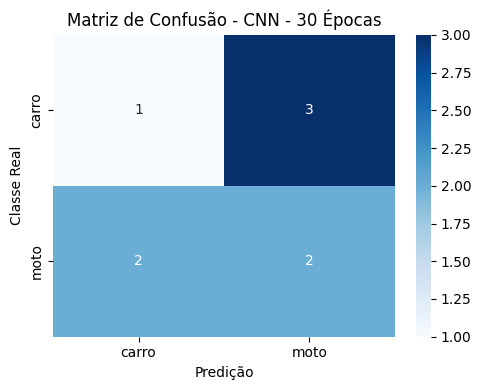


🧾 Relatório de Classificação:
              precision    recall  f1-score   support

       carro       0.33      0.25      0.29         4
        moto       0.40      0.50      0.44         4

    accuracy                           0.38         8
   macro avg       0.37      0.38      0.37         8
weighted avg       0.37      0.38      0.37         8


🔍 Avaliando modelo: CNN - 60 Épocas
📊 Acurácia: 0.6250 | Loss: 0.8873


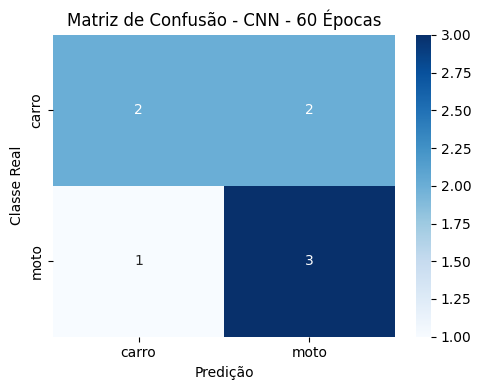


🧾 Relatório de Classificação:
              precision    recall  f1-score   support

       carro       0.67      0.50      0.57         4
        moto       0.60      0.75      0.67         4

    accuracy                           0.62         8
   macro avg       0.63      0.62      0.62         8
weighted avg       0.63      0.62      0.62         8



In [28]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

def avaliar_modelo(modelo, generator, nome_modelo):
    print(f"\n🔍 Avaliando modelo: {nome_modelo}")
    
    # Avaliação direta
    loss, acc = modelo.evaluate(generator, verbose=0)
    print(f"📊 Acurácia: {acc:.4f} | Loss: {loss:.4f}")

    # Predições
    y_prob = modelo.predict(generator, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)
    y_true = generator.classes

    # Matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    class_names = list(generator.class_indices.keys())

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Matriz de Confusão - {nome_modelo}")
    plt.xlabel("Predição")
    plt.ylabel("Classe Real")
    plt.tight_layout()
    plt.show()

    # Relatório detalhado
    print("\n🧾 Relatório de Classificação:")
    print(classification_report(y_true, y_pred, target_names=class_names))

# Avalia os dois modelos
avaliar_modelo(model_30, test_generator, "CNN - 30 Épocas")
avaliar_modelo(model_60, test_generator, "CNN - 60 Épocas")


### Análise dos Resultados: CNN com 30 e 60 Épocas

Após a avaliação no conjunto de teste, foi possível comparar com clareza o desempenho da rede neural convolucional treinada com 30 e 60 épocas.

#### 🔹 CNN – 30 Épocas
- **Acurácia geral**: 37,5%
- **Perda (loss)**: 1.8569
- O modelo acertou apenas **3 de 8 imagens**.
- Teve **baixo recall para a classe "carro" (25%)**, indicando dificuldade em identificar corretamente essa categoria.
- A matriz de confusão mostra **forte confusão entre classes**, especialmente na classificação de motos.

#### 🔹 CNN – 60 Épocas
- **Acurácia geral**: 62,5%
- **Perda (loss)**: 0.8873
- O modelo acertou **5 de 8 imagens**.
- Teve **ótimo recall para "moto" (75%)** e desempenho equilibrado para "carro" (50%).
- A matriz de confusão mostra **melhor separação entre as classes**, indicando aprendizado mais consistente.

---

### ✅ Conclusão

Apesar de possíveis sinais de overfitting nos gráficos, a **CNN treinada com 60 épocas obteve melhor desempenho no conjunto de teste**, com ganhos significativos em todas as métricas (acurácia, recall, f1-score).

Já o modelo com 30 épocas demonstrou dificuldades para aprender padrões visuais robustos e apresentou acurácia muito baixa, indicando que **foi insuficiente para alcançar generalização adequada**.

> 💡 A escolha ideal do número de épocas deve considerar não apenas o desempenho no treino, mas também o equilíbrio com os dados de validação e teste.


## Comparação Final das Abordagens

Após a realização dos experimentos com as três abordagens propostas, os resultados foram consolidados conforme a tabela a seguir:

| Critério                         | YOLOv5 Adaptado (60 ep) | YOLOv5 Tradicional       | CNN do Zero (60 ep)      |
|----------------------------------|---------------------------|---------------------------|---------------------------|
| **Tipo de tarefa**               | Detecção (bounding boxes) | Detecção (pré-treinado)   | Classificação (imagem inteira) |
| **Customização**                | Sim (com dataset próprio) | Não (COCO genérico)       | Sim (rede do zero)       |
| **Facilidade de uso**            | Moderada                  | Alta                      | Alta                      |
| **Precisão/Desempenho**          | mAP@0.5 ≈ **0.9950**      | Boa, mas com falsos positivos (ex: "truck", "train") | Acurácia: **62,5%** |
| **Generalização**                | Alta, focada no domínio   | Ampla, porém genérica     | Razoável, mas limitada    |
| **Tempo de treino**             | Alto (~5-8 min no Colab)  | Nenhum (modelo pronto)    | Médio (~1-2 min)          |
| **Tempo de inferência**         | Rápido (~1s p/ 8 imagens) | Muito rápido (~7s p/ 8 imagens) | Muito rápido             |
| **Visualização de resultados**   | Excelente (caixas, classes, confiança) | Boa (mas genérica)        | Nenhuma (classificação direta) |
| **Melhor cenário de uso**        | Projetos específicos com necessidade de localização | Protótipos rápidos e testes | Classificações simples com objetos centrais |

---

### 🏁 Conclusão

- ✅ **YOLOv5 Adaptado** obteve os melhores resultados em termos de **precisão e foco no domínio**, sendo a melhor escolha quando é necessário **detectar e localizar objetos específicos**
